<a href="https://colab.research.google.com/github/nemoiitkgp/NGRI-SUMMER-INTERNSHIP/blob/main/Effective_stress_and_Pore_Pressure_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Effective stress ($σ$) and Pore Pressure Estimation

#### At first We will try to estimate the Effective Stress $σ$ using the standard Bowers Formula as follows $\sigma = \left( \frac{V - 5000}{A} \right)^{1/B}$
Where A,B are constants,  A and B could be calculated for specific survey.


In [1]:
!pip install devito

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.3/29.3 MB 61.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.1/45.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 7.7 MB/s eta 0:00:00
  Created wheel for cgen: filename=cgen-2025.1-py3-none-any.whl size=19883 sha256=7d2b102c1ef0b7ece7a87b14a9a7dd771731ce0432ae44284f76f722e027954e
  Stored in directory: /root/.cache/pip/wheels/50/1a/02/97f23c102994cf34e52e405bc2e2889aaf463fdcb37d23ca3a
  Created wheel for codepy: filename=codepy-2023.1-py3-none-any.whl size=24869 sha256=ae37809a08156cc0bb6a3f545c9c619119ab61aa36313db3f7691b0a9bb620ab
  Stored in directory: 

## Effective Stress calculation $σ$  Calculation

Starting FWI for 8 iterations with 9 shots...
Objective value is 39293.316406 at iteration 1
Objective value is 24506.722656 at iteration 2
Objective value is 14386.469727 at iteration 3
Objective value is 7907.352539 at iteration 4
Objective value is 3959.928223 at iteration 5
Objective value is 1612.913086 at iteration 6
Objective value is 586.386597 at iteration 7
Objective value is 716.381775 at iteration 8


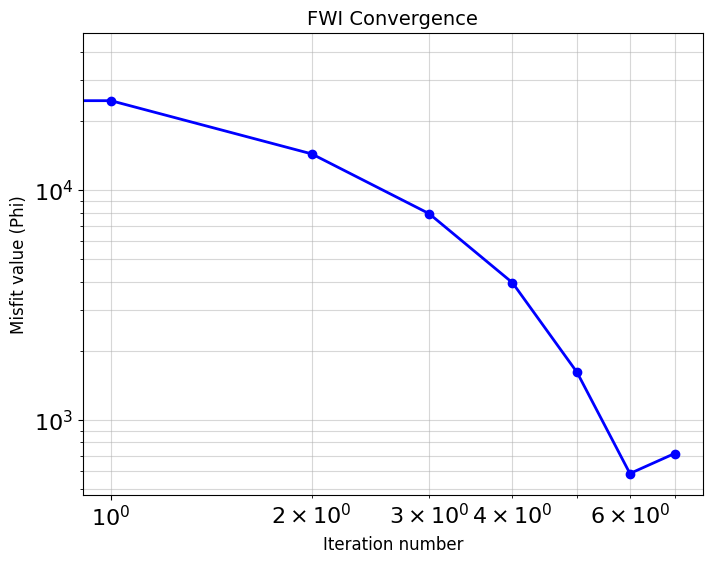


--- Calculating Effective Stress and Directions ---
Original shape with padding: (181, 181)
Physical shape for analysis: (101, 101)


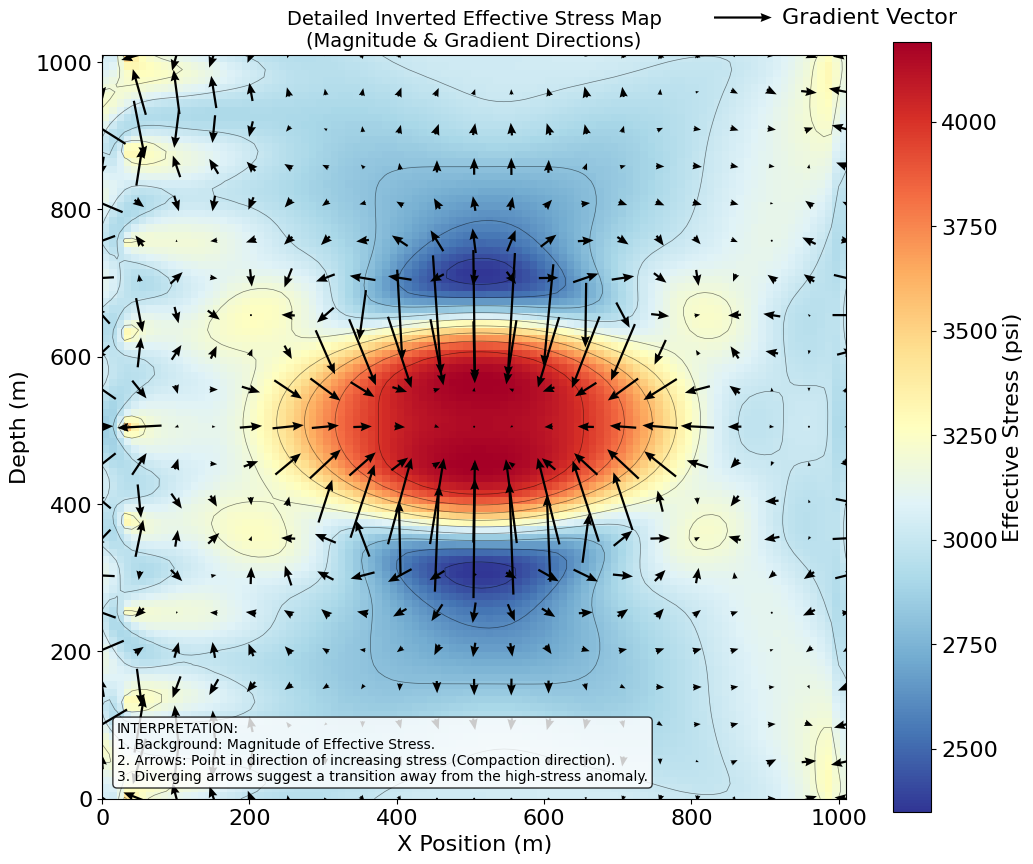

Stress Analysis Complete.
Max Stress: 4191.71 psi
Min Stress: 2349.13 psi


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from devito import configuration, Eq, Operator, Function, TimeFunction, norm, mmax, Min, Max
from examples.seismic import (demo_model, plot_velocity, plot_perturbation,
                              AcquisitionGeometry, Receiver, plot_shotrecord, plot_image)
from examples.seismic.acoustic import AcousticWaveSolver

# =============================================================================
# 1. SETUP AND FWI CONFIGURATION
# =============================================================================

configuration['log-level'] = 'WARNING'

# --- UPDATED PARAMETERS ---
nshots = 9             # Requested: 10
nreceivers = 101        # Requested: 101
fwi_iterations = 8     # Requested: 10
# --------------------------

# Define true and initial model
shape = (101, 101)      # Physical Shape (nx, nz)
spacing = (10., 10.)    # Grid spacing
origin = (0., 0.)
nbl = 40                # Absorbing Boundary Layer size

# True Model (Target)
model = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=nbl)

# Initial Model (Smooth background)
model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=nbl,
                     grid=model.grid)

# Define acquisition geometry: Source
t0 = 0.
tn = 1000.
f0 = 0.010
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, 0] = 20.

# Define acquisition geometry: Receivers
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Create Geometry Object
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates,
                               t0, tn, f0=f0, src_type='Ricker')

# Prepare solver
solver = AcousticWaveSolver(model, geometry, space_order=4)

# Prepare varying source locations
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

# =============================================================================
# 2. HELPER FUNCTIONS FOR FWI
# =============================================================================

def compute_residual(residual, dobs, dsyn):
    if residual.grid.distributor.is_parallel:
        diff_eq = Eq(residual, dsyn.subs({dsyn.dimensions[-1]: residual.dimensions[-1]}) -
                               dobs.subs({dobs.dimensions[-1]: residual.dimensions[-1]}))
        Operator(diff_eq)()
    else:
        residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual

def fwi_gradient(vp_in):
    grad = Function(name="grad", grid=model.grid)
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        geometry.src_positions[0, :] = source_locations[i, :]
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)
        compute_residual(residual, d_obs, d_syn)
        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)
    return objective, grad

def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

# =============================================================================
# 3. RUN FWI LOOP
# =============================================================================

print(f"Starting FWI for {fwi_iterations} iterations with {nshots} shots...")
history = np.zeros((fwi_iterations, 1))

for i in range(0, fwi_iterations):
    phi, direction = fwi_gradient(model0.vp)
    history[i] = phi
    alpha = .05 / mmax(direction)
    update_with_box(model0.vp , alpha , direction)
    print('Objective value is %f at iteration %d' % (phi, i+1))

# =============================================================================
# 4. PLOT CONVERGENCE
# =============================================================================
#NBVAL_SKIP
plt.figure(figsize=(8, 6))
plt.loglog(history, 'b-o', linewidth=2)
plt.xlabel('Iteration number', fontsize=12)
plt.ylabel('Misfit value (Phi)', fontsize=12)
plt.title('FWI Convergence', fontsize=14)
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.show()

# =============================================================================
# 5. BOWERS (1995) STRESS CALCULATION & DIRECTIONS (VISUALIZATION FIXED)
# =============================================================================
#NBVAL_SKIP

print("\n--- Calculating Effective Stress and Directions ---")

# A. Extract Data and Remove Padding (NBL)
# We must slice [nbl:-nbl] to get back to the 101x101 physical domain.
vp_full = model0.vp.data[:]
vp_kms = vp_full[nbl:-nbl, nbl:-nbl]

# Verify Shape
print(f"Original shape with padding: {vp_full.shape}")
print(f"Physical shape for analysis: {vp_kms.shape}")

# Convert to ft/s
vp_fts = vp_kms * 3280.84

# B. Bowers Parameters
A = 4.4567
B = 0.8168
V_matrix = 5000.0

# C. Calculate Effective Stress (psi)
vp_safe = np.maximum(vp_fts, V_matrix + 1.0)
sigma_psi = ((vp_safe - V_matrix) / A) ** (1.0 / B)

# D. Calculate Stress Gradients (Directions)
# Gradients are calculated on the 101x101 grid
grad_x, grad_z = np.gradient(sigma_psi, spacing[0], spacing[1])

# E. Visualization Setup
nx, nz = shape # (101, 101)
x_axis = np.linspace(origin[0], origin[0] + nx*spacing[0], nx)
z_axis = np.linspace(origin[1], origin[1] + nz*spacing[1], nz)

# Create Meshgrid for Quiver
X, Z = np.meshgrid(x_axis, z_axis)

# Transpose data for correct (Z, X) plotting alignment
# (Matplotlib imshow expects [row, col] -> [y, x], but our data is [x, z])
sigma_plot = sigma_psi.T
grad_x_plot = grad_x.T
grad_z_plot = grad_z.T

# F. Plot
fig, ax = plt.subplots(figsize=(12, 10))

# 1. Plot Magnitude (Heatmap)
im = ax.imshow(sigma_plot, origin='upper', cmap='RdYlBu_r',
               extent=[x_axis[0], x_axis[-1], z_axis[-1], z_axis[0]])
cbar = plt.colorbar(im, ax=ax, label='Effective Stress (psi)')

# 2. Plot Contours (Iso-stress lines)
contours = ax.contour(sigma_plot, levels=10, colors='black',
                      linewidths=0.5, alpha=0.5,
                      extent=[x_axis[0], x_axis[-1], z_axis[0], z_axis[-1]])

# 3. Plot Vectors (Arrows)
step = 5 # Plot every 5th arrow to avoid clutter

# FIX: Removed fixed 'scale', increased 'width', added 'pivot'
q = ax.quiver(X[::step, ::step], Z[::step, ::step],
          grad_x_plot[::step, ::step], grad_z_plot[::step, ::step],
          color='black',
          pivot='mid',      # Centers arrow on the grid point
          width=0.003,      # Thicker arrows
          headwidth=4,      # Larger arrow heads
          headlength=5)     # Longer arrow heads

# Add a reference arrow (optional key)
ax.quiverkey(q, X=0.9, Y=1.05, U=10, label='Gradient Vector', labelpos='E')

ax.set_title('Detailed Inverted Effective Stress Map\n(Magnitude & Gradient Directions)', fontsize=14)
ax.set_xlabel('X Position (m)')
ax.set_ylabel('Depth (m)')
ax.invert_yaxis()

# Add Interpretive Text
textstr = "INTERPRETATION:\n" \
          "1. Background: Magnitude of Effective Stress.\n" \
          "2. Arrows: Point in direction of increasing stress (Compaction direction).\n" \
          "3. Diverging arrows suggest a transition away from the high-stress anomaly."
props = dict(boxstyle='round', facecolor='white', alpha=0.8)
ax.text(0.02, 0.02, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='bottom', bbox=props)

plt.show()

print(f"Stress Analysis Complete.")
print(f"Max Stress: {np.max(sigma_psi):.2f} psi")
print(f"Min Stress: {np.min(sigma_psi):.2f} psi")

## Pore Pressure Estimation using  Terzaghi Equation


--- Phase 1: Setup Geometry & Models ---
Setup Complete. Domain: 1010.0x1010.0 m

--- Phase 2: Full Waveform Inversion (Gradient Descent) ---
Starting FWI for 400 iterations...
Iteration 1/400 | Objective: 5594365.00
Iteration 2/400 | Objective: 2663186.00
Iteration 3/400 | Objective: 981157.88
Iteration 4/400 | Objective: 265842.00
Iteration 5/400 | Objective: 113031.07
Iteration 6/400 | Objective: 469979.28
Iteration 7/400 | Objective: 838991.50
Iteration 8/400 | Objective: 101479.06
Iteration 9/400 | Objective: 1102445.00
Iteration 10/400 | Objective: 42300.11
Iteration 11/400 | Objective: 685034.00
Iteration 12/400 | Objective: 528028.56
Iteration 13/400 | Objective: 177572.36
Iteration 14/400 | Objective: 1444483.50
Iteration 15/400 | Objective: 30042.97
Iteration 16/400 | Objective: 657478.94
Iteration 17/400 | Objective: 433386.25
Iteration 18/400 | Objective: 65582.82
Iteration 19/400 | Objective: 1164241.50
Iteration 20/400 | Objective: 66882.80
Iteration 21/400 | Objective: 

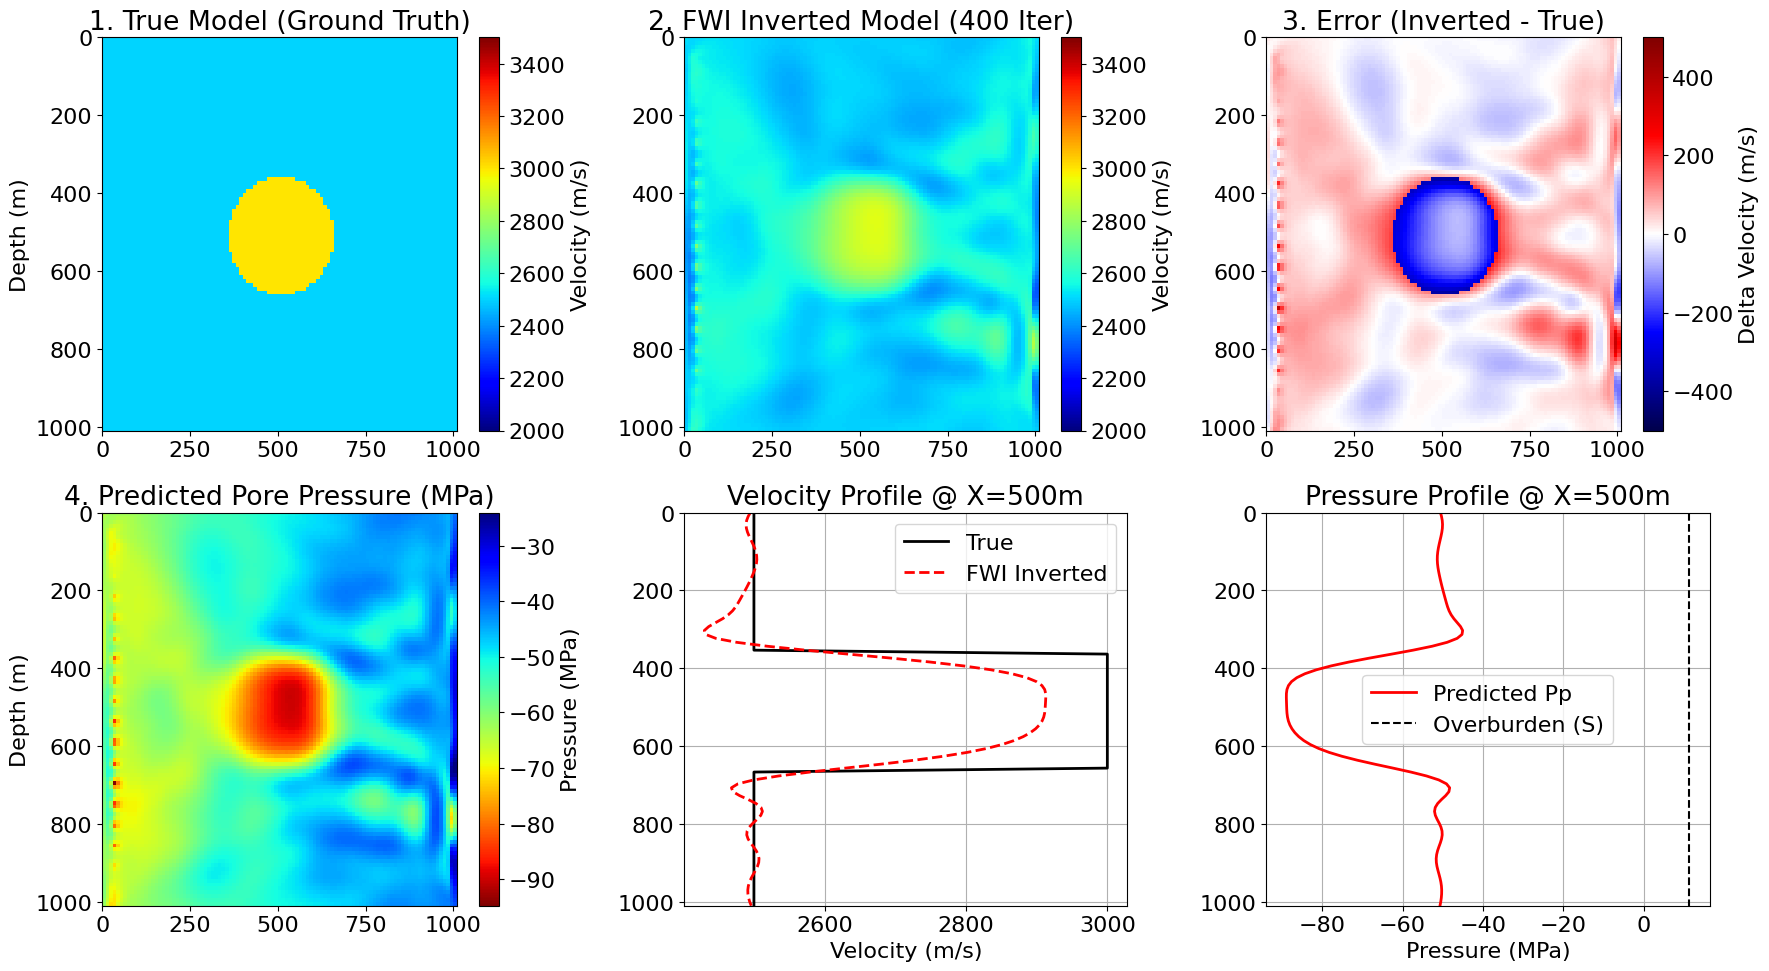

In [10]:
# ==============================================================================
# 1. ENVIRONMENT SETUP
# ==============================================================================
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Silence Devito logging
from devito import configuration
configuration['log-level'] = 'WARNING'

# Standard Devito imports
from devito import Function, TimeFunction, Eq, Operator, Min, Max, mmax, norm
from examples.seismic import demo_model, AcquisitionGeometry, Receiver
from examples.seismic.acoustic import AcousticWaveSolver

# ==============================================================================
# 2. SEISMIC SETUP & GEOMETRY
# ==============================================================================
print("\n--- Phase 1: Setup Geometry & Models ---")

# 1. Define dimensions
shape = (101, 101)       # nx, nz
spacing = (10., 10.)     # dx, dz (meters)
origin = (0., 0.)
nbl = 40                 # Increased Absorbing layer size for stability

# 2. Define Models
# True Model (The Target)
model_true = demo_model('circle-isotropic', vp_circle=3.0, vp_background=2.5,
                        origin=origin, shape=shape, spacing=spacing, nbl=nbl)

# Initial Model (The Starting Point - Smooth background)
model0 = demo_model('circle-isotropic', vp_circle=2.5, vp_background=2.5,
                     origin=origin, shape=shape, spacing=spacing, nbl=nbl,
                     grid=model_true.grid)

# 3. Define Geometry (Transmission Experiment)
# This mimics the geometry from the provided snippet which works best for this model.
nshots = 20
nreceivers = 101
t0 = 0.
tn = 1000.
f0 = 0.010

# Sources: Located on the Left side (X=30m), varying Depth (Z)
src_coords = np.empty((nshots, 2))
src_coords[:, 0] = 30.0
src_coords[:, 1] = np.linspace(0, shape[1]*spacing[1], num=nshots)

# Receivers: Located on the Right side (X=980m), Spanning Depth (Z)
rec_coords = np.empty((nreceivers, 2))
rec_coords[:, 0] = 980.0
rec_coords[:, 1] = np.linspace(0, shape[1]*spacing[1], num=nreceivers)

# Create Geometry object
geometry = AcquisitionGeometry(model_true, rec_coords, src_coords,
                               t0=t0, tn=tn, f0=f0, src_type='Ricker')

# 4. Solver
solver = AcousticWaveSolver(model_true, geometry, space_order=4)

print("Setup Complete. Domain: {}x{} m".format(shape[0]*spacing[0], shape[1]*spacing[1]))

# ==============================================================================
# 3. FWI FUNCTIONS (Based on Devito Example)
# ==============================================================================
print("\n--- Phase 2: Full Waveform Inversion (Gradient Descent) ---")

def compute_residual(residual, dobs, dsyn):
    """
    Computes the residual between observed and synthetic data.
    """
    # A simple data difference is enough in serial
    residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual

def fwi_gradient(vp_in):
    """
    Computes the objective function value and the gradient for the current velocity model.
    """
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model_true.grid)

    # Create placeholders for the data
    residual = Receiver(name='residual', grid=model_true.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model_true.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model_true.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)

    objective = 0.

    # Loop over shots
    for i in range(nshots):
        # Update source location for current shot
        geometry.src_positions[0, :] = src_coords[i, :]

        # 1. Generate True Data (Observed) on the fly using model_true
        # (In production, this is usually loaded from disk, but here we simulate it)
        _, _, _ = solver.forward(vp=model_true.vp, rec=d_obs)

        # 2. Compute Synthetic Data and Wavefield using current model (vp_in)
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

        # 3. Compute Residual (Synthetic - Observed)
        compute_residual(residual, d_obs, d_syn)

        # 4. Update Objective Function (L2 Norm)
        objective += .5 * norm(residual)**2

        # 5. Compute Gradient (Adjoint State Method)
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)

    return objective, grad

def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraints (Min/Max velocity).
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

# ==============================================================================
# 4. FWI OPTIMIZATION LOOP
# ==============================================================================
fwi_iterations = 400  # Number of iterations

print(f"Starting FWI for {fwi_iterations} iterations...")

history = np.zeros((fwi_iterations, 1))

for i in range(fwi_iterations):
    # 1. Compute Gradient and Objective
    phi, direction = fwi_gradient(model0.vp)

    # Store history
    history[i] = phi

    # 2. Calculate Step Length (Alpha)
    # Scaling factor ensures we don't overshoot. .05 is a heuristic from the example.
    max_grad = mmax(direction)
    alpha = .05 / max_grad if max_grad != 0 else 0

    # 3. Update Velocity Model (In-Place)
    # We constrain velocity between 2.0 and 3.5 km/s
    update_with_box(model0.vp, alpha, direction, vmin=2.0, vmax=3.5)

    print(f'Iteration {i+1}/{fwi_iterations} | Objective: {phi:.2f}')

print("FWI Converged.")

# ==============================================================================
# 5. PORE PRESSURE ESTIMATION
# ==============================================================================
print("\n--- Phase 3: Pore Pressure Estimation ---")

# 1. Prepare Velocity Arrays (m/s)
# Slicing to remove absorbing boundary layers (nbl)
slices = (slice(nbl, -nbl), slice(nbl, -nbl))

vp_init_plot = np.full(model0.vp.data[slices].shape, 2500.0) # Pure background for comparison
vp_true_plot = model_true.vp.data[slices] * 1000.0
vp_fwi_plot  = model0.vp.data[slices] * 1000.0  # model0 was updated in place

# 2. Geomechanics Constants
rho_avg = 2300.0   # kg/m3 (Average density)
g = 9.81           # m/s2
M_TO_FT = 3.28084
PSI_TO_PA = 6894.76

nz, nx = vp_fwi_plot.shape
# Depth axis (z is the second dimension in devito usually [x, z], but here let's handle shapes carefully)
# Devito 2D is (x, z).
depth_vector = np.linspace(0, nz*spacing[1], nz) # z axis

# 3. Overburden (Lithostatic Stress)
# Assuming dim 1 is depth (standard 2D matrix visualization)
sigma_v_Pa = np.zeros_like(vp_fwi_plot)
# If shape is (nx, nz), we iterate over nx to fill z
for ix in range(nx):
    sigma_v_Pa[:, ix] = rho_avg * g * depth_vector

# 4. Bowers Effective Stress
# Formula: sigma_eff = ((V - 5000) / A)^(1/B)
A = 3.678
B = 0.743

v_fts = vp_fwi_plot * M_TO_FT
v_term = np.maximum(v_fts - 5000.0, 1.0) # Clamp to avoid Complex numbers/NaNs
sigma_eff_psi = (v_term / A) ** (1.0 / B)
sigma_eff_Pa = sigma_eff_psi * PSI_TO_PA

# 5. Pore Pressure
# Pp = Overburden - Effective Stress
Pp_Pa = sigma_v_Pa - sigma_eff_Pa
Pp_MPa = Pp_Pa / 1e6

# ==============================================================================
# 6. VISUALIZATION
# ==============================================================================
print("\n--- Phase 4: Visualization ---")

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3)

# Axis extent for plotting [x_min, x_max, z_max, z_min]
extent = [0, nx*spacing[0], nz*spacing[1], 0]

# 1. True Model
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(vp_true_plot.T, cmap='jet', aspect='auto', extent=extent, vmin=2000, vmax=3500)
ax1.set_title("1. True Model (Ground Truth)")
ax1.set_ylabel("Depth (m)")
plt.colorbar(im1, ax=ax1, label="Velocity (m/s)")

# 2. FWI Result
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(vp_fwi_plot.T, cmap='jet', aspect='auto', extent=extent, vmin=2000, vmax=3500)
ax2.set_title(f"2. FWI Inverted Model ({fwi_iterations} Iter)")
plt.colorbar(im2, ax=ax2, label="Velocity (m/s)")

# 3. FWI Error (Difference)
ax3 = fig.add_subplot(gs[0, 2])
diff = vp_fwi_plot.T - vp_true_plot.T
im3 = ax3.imshow(diff, cmap='seismic', aspect='auto', extent=extent, vmin=-500, vmax=500)
ax3.set_title("3. Error (Inverted - True)")
plt.colorbar(im3, ax=ax3, label="Delta Velocity (m/s)")

# 4. Predicted Pore Pressure
ax4 = fig.add_subplot(gs[1, 0])
im4 = ax4.imshow(Pp_MPa.T, cmap='jet_r', aspect='auto', extent=extent)
ax4.set_title("4. Predicted Pore Pressure (MPa)")
ax4.set_ylabel("Depth (m)")
plt.colorbar(im4, ax=ax4, label="Pressure (MPa)")

# 5. 1D Velocity Profile (Center of model)
ax5 = fig.add_subplot(gs[1, 1])
mid_x_idx = int(vp_fwi_plot.shape[0] / 2) # Middle X index
ax5.plot(vp_true_plot[mid_x_idx, :], depth_vector, 'k-', linewidth=2, label='True')
ax5.plot(vp_fwi_plot[mid_x_idx, :], depth_vector, 'r--', linewidth=2, label='FWI Inverted')
ax5.set_ylim(depth_vector[-1], 0)
ax5.set_title(f"Velocity Profile @ X={mid_x_idx*10}m")
ax5.set_xlabel("Velocity (m/s)")
ax5.legend()
ax5.grid(True)

# 6. 1D Pressure Profile
ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(Pp_MPa[mid_x_idx, :], depth_vector, 'r-', linewidth=2, label='Predicted Pp')
ax6.plot(sigma_v_Pa[mid_x_idx, :]/1e6, depth_vector, 'k--', label='Overburden (S)')
ax6.set_ylim(depth_vector[-1], 0)
ax6.set_title(f"Pressure Profile @ X={mid_x_idx*10}m")
ax6.set_xlabel("Pressure (MPa)")
ax6.grid(True)
ax6.legend()

plt.tight_layout()
plt.show()